Dependencia:

- pytesseract: É uma biblioteca em Python que serve como uma interface para o Tesseract OCR Engine. O Tesseract é uma ferramenta de código aberto muito utilizada para realizar OCR em imagens.
- xgboost
- lightgbm
- catboost


# Definição do Problema

Classificação de documentos

# Configuração do ambiente de trabablho

- no container docker é instalado o tesseract-ocr
- instalando e importando bibliotecas

In [96]:
import numpy as np 
import pandas as pd
import os
from typing import List

In [97]:
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
#----------SKLEARN--------
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score # ,auc,roc_curve,precision_recall_curve
from sklearn.model_selection import train_test_split # , GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# Coleta de Dados

- Dataset do kaggle: https://www.kaggle.com/datasets/ritvik1909/document-classification-dataset

- Baixar os dados e armazenar em "dataset/www-kaggle-com_datasets_ritvik1909_document-classification-dataset/"]


- Gerencia o fluxo de download e descompactação do dataset.
- Extrai textos das imagens
- Prepara textos para serem usado pela ML
- Lista de palavras que são consideradas stopwords (palavras vazias) para o idioma inglês. 

In [98]:
from ETL_download_dataset_kaggle import download_dataset, unzip_file, get_dataset
from ETL_process_image import process_dataset, draw_bounding_boxes, process_image

# classes/targets que queremos processar para usar no Aprendizado de Máquina que são nomes dos subdiretorios do dataset
required_folders_classes: dict = {'email': 0, 'resume': 1, 'scientific_publication': 2}
path_dataset: str = "dataset/www-kaggle-com_datasets_ritvik1909_document-classification-dataset"
path_df_parquet: str = './DF_process_dataset_ritvik1909_V2.parquet'
link_kaggle_dataset: str = 'ritvik1909/document-classification-dataset' 
path_zip: str = "./dataset/compactados"
zip_file_name: str = f"{path_zip}/document-classification-dataset.zip"

# obtem o dataset para poder ser processado
get_dataset(zip_file_name, link_kaggle_dataset, path_zip, path_dataset)
# processa o dataset de imagens, extraindo textos via OCR e limpando os texto para poder usar no Aprendizado de Máquina
df = process_dataset(f'./{path_dataset}', path_df_parquet, required_folders_classes)
df.columns

Arquivo ./dataset/compactados/document-classification-dataset.zip descompactado com sucesso em dataset/www-kaggle-com_datasets_ritvik1909_document-classification-dataset


Index(['text', 'class_img', 'name', 'dict_ocr', 'class_number'], dtype='object')

In [99]:
df

,text,class_img,name,dict_ocr,class_number
0,reprinted biochemistry copyright american chem...,scientific_publication,doc_000891.png,"{'block_num': [0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2...",2
1,direct nicotinic receptor mediated inhibition ...,scientific_publication,doc_000240.png,"{'block_num': [0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3...",2
2,technical paper study environmental tobacco sm...,scientific_publication,doc_000298.png,"{'block_num': [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1...",2
3,,scientific_publication,doc_000698.png,"{'block_num': [0, 1, 1, 1, 1, 2, 2, 2, 2], 'co...",2
4,tyrosine phosphorylation paxillin accompanies ...,scientific_publication,doc_000509.png,"{'block_num': [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1...",2
...,...,...,...,...,...
160,r j reynolds tobacco international inc japan d...,email,doc_000464.png,"{'block_num': [0, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2...",0
161,week u holding per rose higher share payable u...,email,doc_000471.png,"{'block_num': [0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3...",0
162,tuesday nelson crt kc youth smoking prevention,email,doc_000612.png,"{'block_num': [0, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2...",0
163,juacane lrbm man tommy cc ingram tom threatt h...,email,doc_000448.png,"{'block_num': [0, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2...",0


# Análise Exploratória de Dados (EDA)

### Analisar classes do DF

In [100]:
df['class_img'].value_counts()

class_img
scientific_publication    55
resume                    55
email                     55
Name: count, dtype: int64

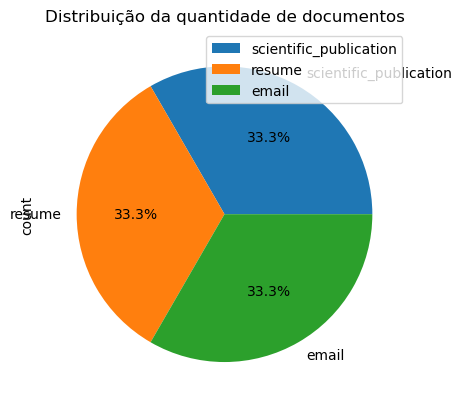

In [101]:
df['class_img'].value_counts().plot(kind='pie',autopct="%.1f%%")
plt.title("Distribuição da quantidade de documentos")
plt.legend()
plt.show()

### Exemplo de e-mail

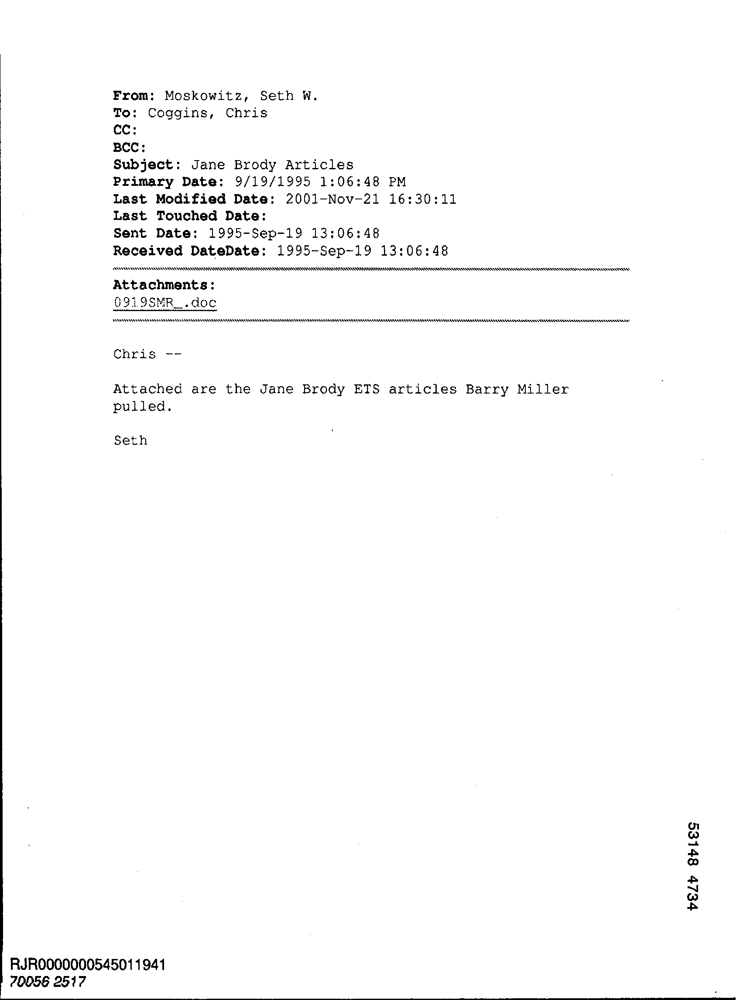

In [102]:
path_example_email = "dataset/www-kaggle-com_datasets_ritvik1909_document-classification-dataset/email/doc_000042.png"
image = Image.open(path_example_email)
image

### Exemplo de Resumo

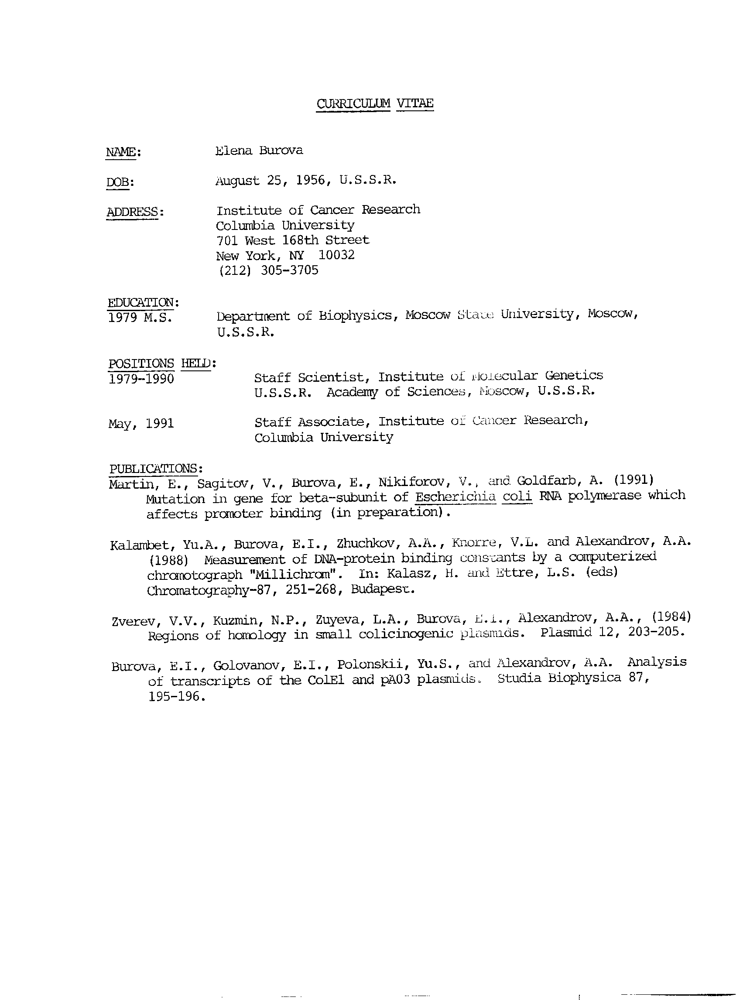

In [103]:
path_exemple_resume  = "dataset/www-kaggle-com_datasets_ritvik1909_document-classification-dataset/resume/doc_000051.png"
image = Image.open(path_exemple_resume)
image

### Exemplo de publicação cientifica

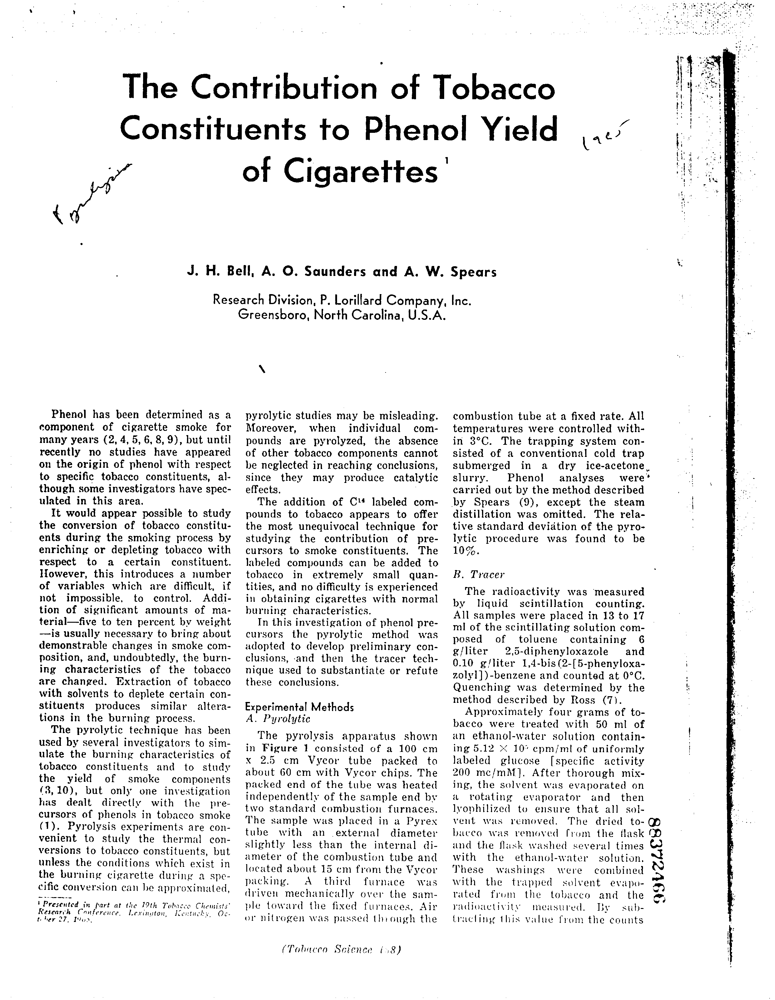

In [104]:
path_example_scientific_publication = "dataset/www-kaggle-com_datasets_ritvik1909_document-classification-dataset/scientific_publication/doc_000016.png"
image = Image.open(path_example_scientific_publication)
image

## Extraindo dados de dentro da imagem via OCR

### Realizar OCR (Reconhecimento Óptico de Caracteres)

In [105]:
# processamento da imagem via OCR
img_text, img_class, img_dict_ocr = process_image(path_example_scientific_publication, make_correct_img_rotation=False)
img_text

'contribution tobacco constituent phenol bell saunders w spear research division p lorillard company inc greensboro north carolina usa phenol determined study may misleading combustion tube fixed rate component cigarette smoke moreover com temperature controlled many year pound pyrolyzed absence c trapping system recently study tobacco component eannot conventional cold trap origin phenol respect reaching submerged tobaceo constituent al since may produce slurry phenol though investigator spec carried method ulated area addition labeled com spear except steam tt would appear possible study pound tobseco appears offer distillation omitted conversion tobacco constitu unequivocal technique standard pyro smoking process studying contribution procedure found depleting tobacco cursor smoke constituent compound added however introduces number tobacco quan tracer difficult tities experienced ing investigation phenol usually necessary bring pyrolytic method demonstrable change smoke com develop

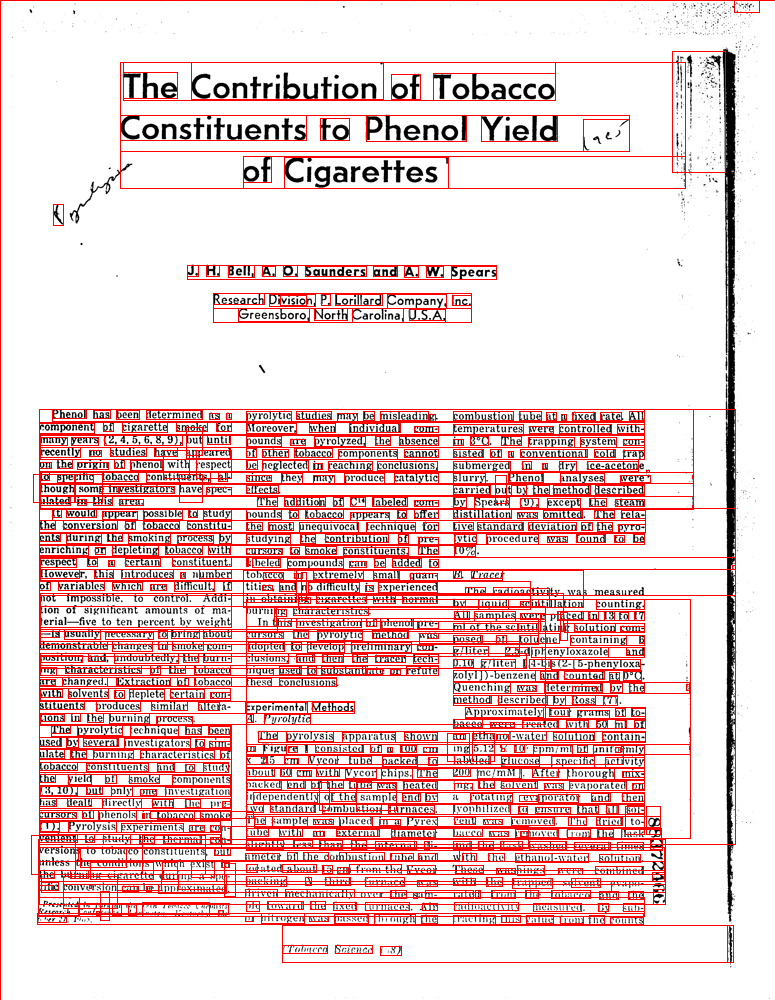

In [106]:
# Converte dict para DF pandas
img_df_ocr = pd.DataFrame(img_dict_ocr)
# contorna texto
image = draw_bounding_boxes(image, img_df_ocr)
image

# Dividindo o dataframe em treino e teste (split)

In [107]:
x_train, x_test, y_train, y_test = train_test_split(df['text'], df['class_number'], shuffle=True, test_size=0.10)
print("Quantidade para treino: " + str(x_train.shape))
print("Quantidade para teste: " + str(x_test.shape))

Quantidade para treino: (148,)
Quantidade para teste: (17,)


In [108]:
x_train

88     al sketch give following key begin withthe for...
24     separation quantitation monovalent anionic cat...
53     use monoclonal antilight subunit antibody stud...
64     personal data surname bell first name stuart d...
145    karon may paula here report way one titled inc...
                             ...                        
45     de prevention nicotine intoxication steroid mé...
27     air quality passenger cabin dc md aircraft ab ...
115    sent thursday march pm tod goldman brendan gre...
49     incidence lung tumor albino mouse exposed smok...
55     director last berger mark sketch give followin...
Name: text, Length: 148, dtype: object

In [109]:
print(y_train)

88     1
24     2
53     2
64     1
145    0
      ..
45     2
27     2
115    0
49     2
55     1
Name: class_number, Length: 148, dtype: int64


Abordagem abaixo é útil para representar textos de forma numérica para serem usados como entrada em modelos de aprendizado de máquina, como classificadores ou modelos de clustering.

O TfidfVectorizer do scikit-learn é uma ferramenta que converte uma coleção de documentos de texto em uma matriz de características TF-IDF (Term Frequency-Inverse Document Frequency).  Matriz esparsa, que é eficiente para armazenar dados quando a maioria dos valores são zeros. A matriz esparsa economiza memória ao armazenar apenas os índices e valores dos elementos não-zero. A matriz densa ocupa mais memória porque armazena todos os elementos, incluindo os zeros.


- Criação de uma matriz TF-IDF para representar dados textuais. TF-IDF (Term Frequency-Inverse Document Frequency) é uma técnica para extrair características de texto que refletem a importância de uma palavra ou n-grama em relação a um documento em um corpus.

- TfidfVectorizer: Esta é uma classe do sklearn.feature_extraction.text que converte uma coleção de documentos de texto em uma matriz TF-IDF (Term Frequency-Inverse Document Frequency).

- ngram_range=(2,5): Define que serão considerados n-grams de tamanho mínimo 2 e máximo 5. Isso significa que o vetorizador criará características que são combinações de 2 até 5 palavras consecutivas.

- max_df=0.95: Remove termos que aparecem em mais de 95% dos documentos. Isso ajuda a remover palavras muito comuns que não são discriminativas.

- min_df=2: Remove termos que aparecem em menos de 2 documentos. Isso ajuda a remover palavras raras que podem não contribuir muito para o modelo.

- max_features=10000: Limita o número máximo de características (palavras ou n-grams) a serem extraídas. Aqui, será limitado a 10.000 características com base na frequência TF-IDF mais alta.


In [110]:
# Configurando o TfidfVectorizer
tfidf = TfidfVectorizer(ngram_range=(2,5), max_df=0.95, min_df=2 ,max_features=10000)
tfidf

TfidfVectorizer(max_df=0.95, max_features=10000, min_df=2, ngram_range=(2, 5))

fit_transform(x_train): Este método ajusta o vetorizador ao conjunto de dados de treino x_train e, em seguida, transforma x_train em uma matriz TF-IDF. Isso significa que ele aprende o vocabulário do conjunto de treinamento e transforma cada documento (no caso, cada texto em x_train) em uma representação numérica usando TF-IDF.

A matriz resultante de tfidf.fit_transform(x_train) é uma matriz esparsa (tipicamente CSR - Compressed Sparse Row format), que é eficiente em termos de memória. Convertendo-a em uma matriz densa do NumPy.

In [111]:
# Ajustando e transformando os dados de treinamento
tfidf_train = tfidf.fit_transform(x_train)

transform(x_test): transformando os dados de teste x_test em uma matriz TF-IDF usando o vocabulário aprendido durante o ajuste (fit_transform). É importante usar transform nos dados de teste, não fit_transform, porque queremos aplicar o mesmo vocabulário do conjunto de treinamento aos dados de teste.

In [112]:
# Convertendo a matriz esparsa em uma matriz densa
tfidf_test = tfidf.transform(x_test)

In [113]:
tfidf_train.A.shape

(148, 821)

In [114]:
# matriz esparsa de TF-IDF.
tfidf_train.A

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

# Construindo o Modelo

Regressão Logistica

utilizando a classe LogisticRegression do scikit-learn para treinar um modelo de regressão logística com os dados de treinamento que foram transformados usando o vetorizador TF-IDF.

criando uma instância do modelo de Regressão Logística. A regressão logística é um algoritmo de aprendizado supervisionado usado para problemas de classificação binária e multiclasse.

In [115]:
model = LogisticRegression()

# Treinamento do Modelo


tfidf_train.A é a matriz de características de treinamento transformada usando TF-IDF. O método .A converte a matriz esparsa para uma matriz densa, que é esperada pelo método fit da regressão logística.

y_train são os rótulos correspondentes aos exemplos de treinamento. Cada rótulo indica a classe à qual o exemplo pertence.

O vetorizador TF-IDF (tfidf) foi ajustado aos dados de treinamento (x_train) antes deste treinamento, definindo o vocabulário e calculando os pesos TF-IDF para cada palavra ou conjunto de palavras nos documentos.

tfidf_train.A é a matriz de características transformada usando TF-IDF. Ela contém representações numéricas das palavras presentes nos documentos de treinamento.

model.fit(tfidf_train.A, y_train) usa essas representações para treinar o modelo de regressão logística, onde tfidf_train.A são as características de entrada e y_train são os rótulos correspondentes às classes dos documentos de treinamento.

Após o treinamento, o modelo estará ajustado aos dados de treinamento e poderá ser usado para fazer previsões sobre novos dados (nesse caso, usando tfidf_test para transformar os dados de teste e model.predict para fazer previsões).

Este procedimento faz parte do fluxo típico de trabalho em aprendizado de máquina supervisionado para classificação de texto utilizando o método TF-IDF em conjunto com a regressão logística.

In [116]:
model.fit(tfidf_train.A, y_train)

LogisticRegression()

# Previsões

utilizando o modelo de regressão logística treinado (model) para fazer previsões sobre os dados de teste que foram transformados usando TF-IDF (tfidf_test).

model.predict() é o método utilizado para fazer previsões com o modelo treinado.

tfidf_test.A é a matriz de características de teste transformada usando TF-IDF. Assim como no treinamento, .A converte a matriz esparsa para uma matriz densa, que é esperada pelo método predict da regressão logística.


Após treinar o modelo de regressão logística com os dados de treinamento, agora está usando o modelo para prever as classes dos dados de teste.

tfidf_test.A contém as representações TF-IDF dos dados de teste, ou seja, como cada palavra nos documentos de teste foi transformada numericamente usando TF-IDF.

model.predict(tfidf_test.A) aplica o modelo treinado aos dados de teste para prever a classe de cada exemplo de teste.

O resultado das previsões é armazenado em y_pred, que é uma lista ou matriz (dependendo da forma de tfidf_test.A) contendo as classes previstas para os exemplos de teste.

y_pred contém as classes previstas para os exemplos de teste. Cada valor em y_pred corresponde à classe prevista para o exemplo correspondente em tfidf_test.A.

Com essas previsões, pode avaliar o desempenho do seu modelo comparando y_pred com os rótulos reais (y_test) dos dados de teste.

Este é o passo final em muitos fluxos de trabalho de aprendizado de máquina supervisionado, onde após treinar o modelo, fazemos previsões sobre novos dados para avaliar a eficácia do modelo treinado.

In [117]:
# Previsões com dados de test
y_pred = model.predict(tfidf_test.A)
y_pred

array([1, 0, 0, 2, 0, 0, 0, 1, 0, 1, 0, 2, 1, 1, 2, 1, 0])

### Previsões com dados de treinamento para detectar overfitting

utilizando o modelo de regressão logística treinado (model) para fazer previsões sobre os dados de treinamento que foram transformados usando TF-IDF (tfidf_train).

Após treinar o modelo de regressão logística com os dados de treinamento, está usando o modelo para prever as classes dos próprios dados de treinamento.

útil para verificar se o modelo está "decorando" os dados de treinamento, o que poderia indicar overfitting.

In [118]:
y_pred_tr = model.predict(tfidf_train.A)
y_pred_tr[:10]

array([1, 2, 2, 1, 0, 0, 1, 2, 2, 0])

# Avaliação do modelo

In [119]:
print("Matriz de confusão:\n",confusion_matrix(y_test, y_pred))

Matriz de confusão:
 [[5 0 0]
 [0 6 0]
 [3 0 3]]


In [120]:

print("Relatório de Classificação:\n",classification_report(y_test,y_pred))

Relatório de Classificação:
               precision    recall  f1-score   support

           0       0.62      1.00      0.77         5
           1       1.00      1.00      1.00         6
           2       1.00      0.50      0.67         6

    accuracy                           0.82        17
   macro avg       0.88      0.83      0.81        17
weighted avg       0.89      0.82      0.81        17



In [121]:
print("Confusion Matrix:\n",confusion_matrix(y_train,y_pred_tr))

Confusion Matrix:
 [[50  0  0]
 [ 3 46  0]
 [10  0 39]]


In [122]:
print("Classification Report:\n",classification_report(y_train,y_pred_tr))

Classification Report:
               precision    recall  f1-score   support

           0       0.79      1.00      0.88        50
           1       1.00      0.94      0.97        49
           2       1.00      0.80      0.89        49

    accuracy                           0.91       148
   macro avg       0.93      0.91      0.91       148
weighted avg       0.93      0.91      0.91       148



In [123]:
print(f"Accuracy on Test Data: {accuracy_score(y_test,y_pred)*100:.2f} %")
print(f"Accuracy on Train Data: {accuracy_score(y_train,y_pred_tr)*100:.2f} %")

Accuracy on Test Data: 82.35 %
Accuracy on Train Data: 91.22 %


# Regressão Logística

In [124]:
lg_model = LogisticRegression(max_iter=2000,solver='liblinear',C=100)
lg_model.fit(tfidf_train.A,y_train)

LogisticRegression(C=100, max_iter=2000, solver='liblinear')

In [125]:
y_pred = lg_model.predict(tfidf_test.A)
y_pred

array([1, 0, 0, 2, 0, 0, 0, 1, 0, 1, 0, 2, 1, 1, 2, 1, 0])

In [126]:
print("Confusion Matrix:\n",confusion_matrix(y_test,y_pred))

Confusion Matrix:
 [[5 0 0]
 [0 6 0]
 [3 0 3]]


In [127]:
print("Classification Report:\n",classification_report(y_test,y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.62      1.00      0.77         5
           1       1.00      1.00      1.00         6
           2       1.00      0.50      0.67         6

    accuracy                           0.82        17
   macro avg       0.88      0.83      0.81        17
weighted avg       0.89      0.82      0.81        17



In [128]:
y_test.values

array([1, 2, 0, 2, 2, 0, 0, 1, 0, 1, 0, 2, 1, 1, 2, 1, 2])

In [129]:
print(f"Accuracy on Test Data: {accuracy_score(y_test, y_pred)*100:.2f} %")

Accuracy on Test Data: 82.35 %


# OUTRO TREINAMENTO

### Converter a coluna target em colunas binárias
- Usa pd.get_dummies para converter a coluna target em várias colunas binárias, uma para cada classe.

In [130]:

df_dummies = pd.get_dummies(df['class_img'], prefix='class')
df_dummies

,class_email,class_resume,class_scientific_publication
0,False,False,True
1,False,False,True
2,False,False,True
3,False,False,True
4,False,False,True
...,...,...,...
160,True,False,False
161,True,False,False
162,True,False,False
163,True,False,False


In [131]:
# Dividir o DataFrame em conjunto de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(df['text'], df_dummies, shuffle=True, test_size=0.10)

In [132]:
# Vetorização do texto usando TF-IDF
vectorizer = TfidfVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# Treinar o modelo para cada classe binária
models = {}
for class_name in y_train.columns:
    clf = LogisticRegression()
    clf.fit(X_train_vec, y_train[class_name])
    models[class_name] = clf

# Fazer previsões para cada classe binária
y_pred = pd.DataFrame(index=X_test.index, columns=y_train.columns)
for class_name, clf in models.items():
    y_pred[class_name] = clf.predict(X_test_vec)

# Avaliação dos resultados
for class_name in y_train.columns:
    print(f"Classe: {class_name}")
    print(f"Matriz de confusão:\n{confusion_matrix(y_test[class_name], y_pred[class_name])}")
    print(f"Acurácia: {accuracy_score(y_test[class_name], y_pred[class_name])}\n")

# Converter as previsões binárias de volta para uma coluna de classes
y_test_single = y_test.idxmax(axis=1)
y_pred_single = y_pred.idxmax(axis=1)

# Calcular e exibir a acurácia geral
overall_accuracy = accuracy_score(y_test_single, y_pred_single)
print(f"Acurácia geral: {overall_accuracy}")

Classe: class_email
Matriz de confusão:
[[11  0]
 [ 4  2]]
Acurácia: 0.7647058823529411

Classe: class_resume
Matriz de confusão:
[[11  0]
 [ 1  5]]
Acurácia: 0.9411764705882353

Classe: class_scientific_publication
Matriz de confusão:
[[12  0]
 [ 5  0]]
Acurácia: 0.7058823529411765

Acurácia geral: 0.6470588235294118
